<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/blob/main/03_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Project
This project builds a food classification model using transfer learning on the Food101 dataset with TensorFlow.

In [ ]:
# lets check our GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8a8dcdae-36a9-a901-1846-a773e6ca15ed)


# Get Helper Functions
Downloads a Python file with pre-built helper functions from GitHub and imports specific utilities. These functions simplify repetitive tasks like logging to TensorBoard, plotting training curves, unzipping datasets, and exploring directory structures. Reusing tested utilities saves time and ensures consistency.

In [ ]:
!wget https://raw.githubusercontent.com/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/refs/heads/main/helper_functions.py


--2025-03-26 22:32:13--  https://raw.githubusercontent.com/Prashanna-Raj-Pandit/Transfer-Learning--TensorFlow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10129 (9.9K) [text/plain]
Saving to: ‘helper_functions.py.5’

helper_functions.py 100%[===================>]   9.89K  --.-KB/s    in 0s      

2025-03-26 22:32:14 (68.3 MB/s) - ‘helper_functions.py.5’ saved [10129/10129]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

# Load Food101 Dataset with TensorFlow Datasets
Let's loads the Food101 dataset directly from TensorFlow Datasets (TFDS), splitting it into training and validation sets. The as_supervised=True argument provides image-label pairs, and with_info=True gives metadata (e.g., class names). Using TFDS simplifies dataset management and ensures standardized preprocessing.

In [ ]:
import tensorflow_datasets as tfds
(train_data,test_data),info=tfds.load(name="food101",split=["train","validation"],
                                 shuffle_files=True,
                                 as_supervised=True,
                                 with_info=True)

## Explore Dataset Metadata

In [ ]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names=info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

## Inspect a Training Sample

In [ ]:
train_data_sample=train_data.take(1)
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:

for image,label in train_data_sample:
  print("Image datatype:",image.dtype)
  print("Image shape:",image.shape)
  print("Label:",label)
  print("classname:",class_names[label.numpy()])

Image datatype: <dtype: 'uint8'>
Image shape: (512, 289, 3)
Label: tf.Tensor(45, shape=(), dtype=int64)
classname: frozen_yogurt


In [ ]:
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

## Visualize a Single Image

Text(0.5, 1.0, 'Original Train Image: frozen_yogurt')

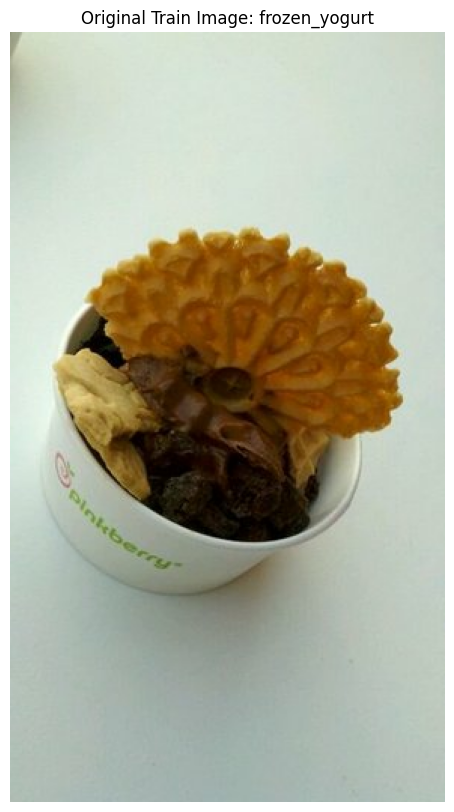

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis("off")
plt.title(f"Original Train Image: {class_names[label.numpy()]}")

## Visualizing some random Training Images

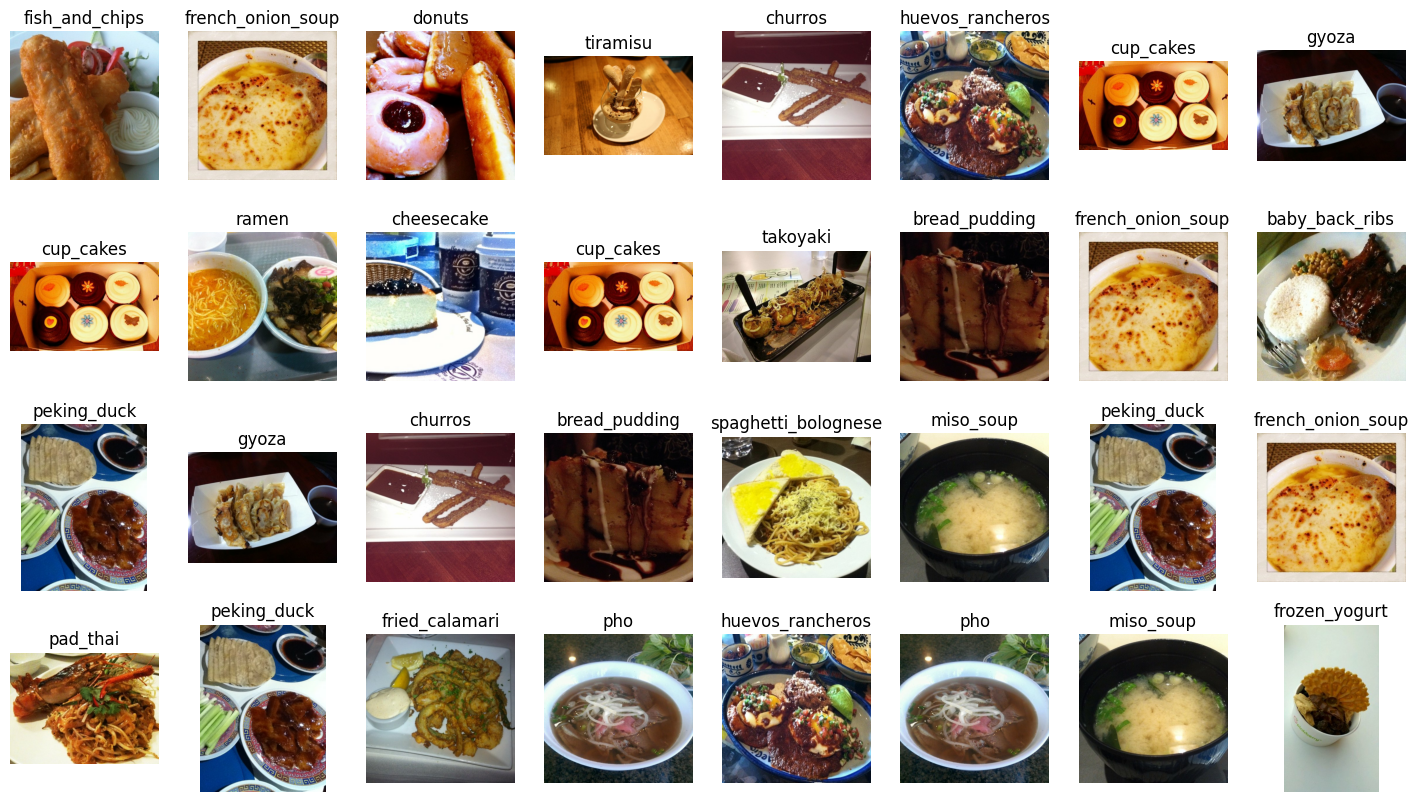

In [ ]:

plt.figure(figsize=(18,10))
num_rows = 4
num_cols = 8

for i in range(num_rows*num_cols):
  for image, label in train_data.take(1):
      ax = plt.subplot(num_rows, num_cols, i + 1)
      plt.imshow(image)
      plt.title(class_names[label.numpy()])
      plt.axis("off")

# Preprocess Image
Lets define a function to resize images to 224x224 (a common input size for pre-trained models) and convert them to float32. Preprocessing standardizes the data, making it compatible with the model and improving numerical stability during training.

In [ ]:
def preprocessing_image(image,label,img_shape=224):
  """
  converts the image datatype from unit8 to float32 and reshape it to (image_shape,image_shape,color_channels) (224,224 3)
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label # this retutn a tuple of (float32 image, label)

In [ ]:
preprocessed_sample_image=preprocessing_image(image,label)

print("Before Preprocessing:",image.shape)
print("After Preprocessing:",preprocessed_sample_image)

Before Preprocessing: (512, 289, 3)
After Preprocessing: (<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[147.19739, 153.19739, 127.19739],
        [157.22768, 163.22768, 137.22768],
        [158.09805, 164.09805, 138.09805],
        ...,
        [197.     , 209.     , 197.54907],
        [197.     , 209.     , 199.     ],
        [198.09914, 208.38936, 199.24425]],

       [[154.69467, 160.69467, 134.69467],
        [155.87053, 161.87053, 135.87053],
        [158.39908, 164.39908, 138.39908],
        ...,
        [197.     , 209.     , 197.54907],
        [197.     , 209.     , 199.     ],
        [196.32831, 206.61853, 195.76364]],

       [[154.56473, 158.56473, 133.56473],
        [153.49234, 158.17635, 132.83435],
        [157.76036, 163.3318 , 137.54608],
        ...,
        [197.     , 209.     , 197.54907],
        [197.     , 209.     , 197.87054],
        [197.85489, 208.51149, 197.1832 ]],

       ...,

       [[176.88599, 189.88599, 180.88599],
        [175

## Batch and Optimize Dataset
Applies preprocessing to the datasets, shuffles the training data (to reduce overfitting), batches it into groups of 32 (for efficient training), and prefetches data (to minimize I/O bottlenecks). These optimizations enhance training speed and model generalization.The level of parallelism can be specified by the num_parallel_calls argument

In [ ]:
# Batch and prepare dataset
train_data=train_data.map(map_func=preprocessing_image,num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data=test_data.map(map_func=preprocessing_image,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data,train_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
train_data_sample=train_data.take(1)
for image,label in train_data_sample:
  print("Image datatype:",image.dtype)
  print("Image shape:",image.shape)
  print("Label:",label)

Image datatype: <dtype: 'float32'>
Image shape: (32, 224, 224, 3)
Label: tf.Tensor(
[39 70  1 30 75  9 89 21 86 49 19 39  9 46 62 83 89 23 48 45  3 37 13 27
 34 13 49 66 27 54 46  6], shape=(32,), dtype=int64)


# Set Up Modeling Callbacks
Configures a TensorBoard callback (for training visualization) and a ModelCheckpoint callback (to save the best model weights based on validation accuracy). Checkpoints preserve the best model, preventing loss of progress if training degrades.

In [ ]:
# creating modelling callbacks. tensorboard and model checkpoint callback
from helper_functions import create_tensorboard_callback

# model checkpoint
checkpoint_path="checkpoint/food101_checkpoint.weights.h5"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       monitor='val_acc',
                                                       verbose=1,
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       save_freq="epoch",

                                                      )

# Enable Mixed Precision Training
Activates mixed precision training, using float16 for most computations while maintaining float32 for critical parts. This speeds up training and reduces memory usage on compatible GPUs, improving efficiency without sacrificing accuracy.

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

# Build Feature Extraction Model
Builds a feature extraction model using EfficientNetV2B0 (frozen) as the base, adding a pooling layer and a dense layer for 101 classes. Uses sparse categorical cross-entropy since labels are integers. This leverages pre-trained features for faster training on Food101.

In [ ]:
# build feature extraction model
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")
x=base_model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x=tf.keras.layers.Dense(len(class_names))(x)
outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
model=tf.keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [ ]:
label # label is in integer so we use sparse categorical cross entropy

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([39, 70,  1, 30, 75,  9, 89, 21, 86, 49, 19, 39,  9, 46, 62, 83, 89,
       23, 48, 45,  3, 37, 13, 27, 34, 13, 49, 66, 27, 54, 46,  6])>

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetv2-b0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [ ]:
for layer_number,layer in enumerate(model.layers[1].layers):
  print(layer_number,layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

0 input_layer_1 False float32 <DTypePolicy "mixed_float16">
1 rescaling_1 False float32 <DTypePolicy "mixed_float16">
2 normalization_1 False float32 <DTypePolicy "mixed_float16">
3 stem_conv False float32 <DTypePolicy "mixed_float16">
4 stem_bn False float32 <DTypePolicy "mixed_float16">
5 stem_activation False float32 <DTypePolicy "mixed_float16">
6 block1a_project_conv False float32 <DTypePolicy "mixed_float16">
7 block1a_project_bn False float32 <DTypePolicy "mixed_float16">
8 block1a_project_activation False float32 <DTypePolicy "mixed_float16">
9 block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
10 block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
11 block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
12 block2a_project_conv False float32 <DTypePolicy "mixed_float16">
13 block2a_project_bn False float32 <DTypePolicy "mixed_float16">
14 block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
15 block2b_expand_bn False float32 <DT

# Train Feature Extraction Model
Trains the model for 3 epochs, using 15% of test data for validation. The TensorBoard callback logs progress, and ModelCheckpoint saves the best weights. This initial training establishes a baseline performance.

In [ ]:
model_history=model.fit(train_data,
          epochs=3,
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          steps_per_epoch=len(train_data),
          callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="food_vision"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/food_vision/20250326-223226
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 242s 87ms/step - accuracy: 0.4553 - loss: 2.3668 - val_accuracy: 0.6928 - val_loss: 1.1657
Epoch 2/3


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 256s 92ms/step - accuracy: 0.6572 - loss: 1.3324 - val_accuracy: 0.7203 - val_loss: 1.0546
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 179s 75ms/step - accuracy: 0.6920 - loss: 1.1852 - val_accuracy: 0.7299 - val_loss: 1.0026


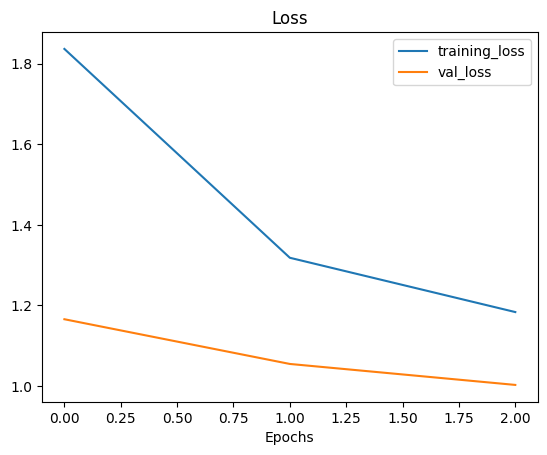

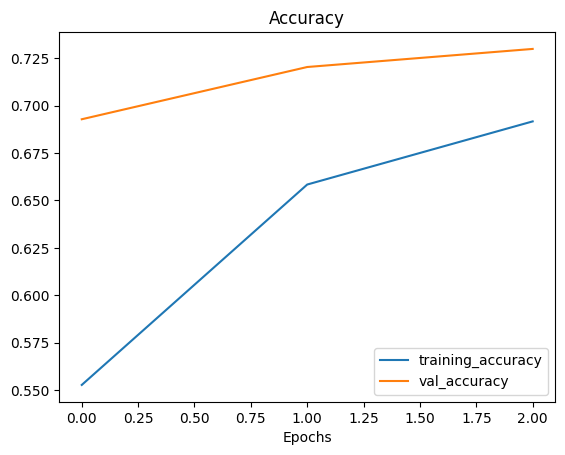

In [ ]:
plot_loss_curves(model_history)

# Fine-Tune Last 10 Layers
Lets define a reusable model creation function and unfreezes the last 10 layers of EfficientNetV2B0 for fine-tuning. Fine-tuning adapts the pre-trained model to Food101, potentially improving accuracy by adjusting deeper features.

In [ ]:
def create_base_model():
  input_shape=(224,224,3)
  base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable=False

  inputs=tf.keras.layers.Input(shape=input_shape,name="input_layer")
  x=base_model(inputs,training=False)
  x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
  x=tf.keras.layers.Dense(len(class_names))(x)
  outputs=tf.keras.layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)
  model=tf.keras.Model(inputs,outputs)
  return model

In [ ]:
model=create_base_model()
model.trainable=True
for layer_number,layer in enumerate(model.layers[1].layers[:-10]):
  layer.trainable=False
for layer_number,layer in enumerate(model.layers[1].layers):
   print(layer_number,layer.name,layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [ ]:
checkpoint_path="checkpoint/fine_tune/fine_tune_1.weights.h5"
# Create ModelCheckpoint callback to save best model during fine-tuning
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Recompiliing: because we make changes to our base model
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # we always lower the LR by 10X in fine tune to reduce overfitting
                metrics=['accuracy'])

In [ ]:
fine_tune_epoch=3+3
model_history_fine_tune_1=model.fit(train_data,
                                  epochs=fine_tune_epoch,
                                  initial_epoch=model_history.epoch[-1],
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  steps_per_epoch=len(train_data),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="food101_fine_tune_1"),model_checkpoint]
                                  )

Saving TensorBoard log files to: transfer_learning/food101_fine_tune_1/20250326-224346
Epoch 3/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2317 - loss: 3.7563

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 237s 86ms/step - accuracy: 0.2318 - loss: 3.7561 - val_accuracy: 0.5498 - val_loss: 2.1663
Epoch 4/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5238 - loss: 2.2109

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 258s 91ms/step - accuracy: 0.5238 - loss: 2.2108 - val_accuracy: 0.6147 - val_loss: 1.6756
Epoch 5/6
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5774 - loss: 1.8326

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.5774 - loss: 1.8326 - val_accuracy: 0.6523 - val_loss: 1.4738
Epoch 6/6
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6027 - loss: 1.6617

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.6027 - loss: 1.6616 - val_accuracy: 0.6655 - val_loss: 1.3643


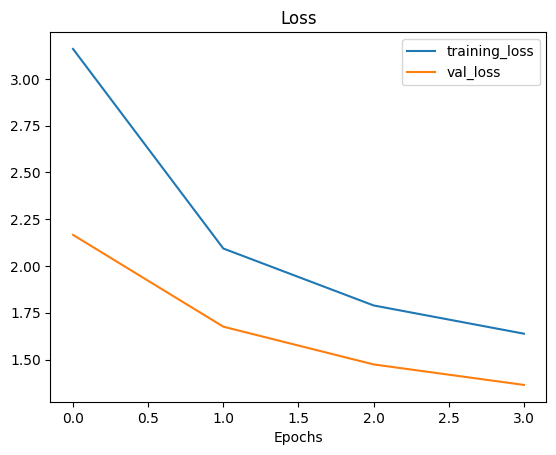

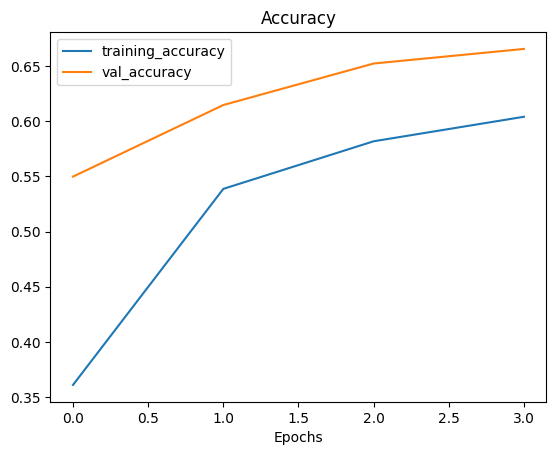

In [ ]:
plot_loss_curves(model_history_fine_tune_1)

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.6629 - loss: 1.3722


[1.3763567209243774, 0.661425769329071]

In [ ]:
model.save("food_vision_fine_tune.keras")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("food_vision_fine_tune.keras")
loaded_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 8 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_7 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,178,080 (23.57 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 129,387 (505.43 KB)

In [ ]:
evaluate_save_model=loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.6623 - loss: 1.3729


# Fine-Tune All Layers
Unfreezes all layers of the base model for full fine-tuning. This allows the entire network to adapt to Food101, potentially maximizing accuracy at the risk of overfitting if not controlled.

In [ ]:
model=create_base_model()
model.trainable=True
for layer_number,layer in enumerate(model.layers[1].layers):
  layer.trainable=True
  print(layer_number,layer.name,layer.trainable)

0 input_layer_3 True
1 rescaling_3 True
2 normalization_3 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 blo

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetv2-b0 False
global_average_pooling_layer True
dense_3 True
softmax_float32 True


## Add Advanced Callbacks
Adding EarlyStopping (stops training if validation loss doesn’t improve for 3 epochs), ModelCheckpoint (saves best weights), and ReduceLROnPlateau (reduces learning rate by 5x if loss stalls). These prevent overfitting and optimize training efficiency.

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=3)
checkpoint_path="checkpoint/fine_tune/fine_tune_2.weights.h5"
# Create ModelCheckpoint callback to save best model during fine-tuning
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")
# creating learning rate reduction callback
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.2, # multiply the learning rate by 0.2 (i.e reduce by 5x)
                                               patience=2,
                                               verbose=1, # print out when learning rate goes down
                                               min_lr=1e-7)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
model_history_fine_tune_2=model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    initial_epoch=model_history.epoch[-1],
                                    validation_steps=int(0.15*(len(test_data))),
                                    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="food101_fine_tune2"),
                                               model_checkpoint,
                                               early_stopping,
                                               reduce_lr])

Saving TensorBoard log files to: transfer_learning/food101_fine_tune2/20250326-230512
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5771 - loss: 1.7549

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 306s 127ms/step - accuracy: 0.5771 - loss: 1.7547 - val_accuracy: 0.7926 - val_loss: 0.7738 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7511 - loss: 0.9550

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 257s 100ms/step - accuracy: 0.7511 - loss: 0.9550 - val_accuracy: 0.8204 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 5/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8193 - loss: 0.6806

In [ ]:
plot_loss_curves(model_history_fine_tune_2)

In [ ]:
model.evaluate(test_data)